# Load Documents

In [1]:
from pipeline.doc_load.document_loader import multi_xscience_get_text

train, test, val = multi_xscience_get_text()

In [2]:
def check_size(text, list_to_put=[]):
    words = text.split()
    if len(words)> 2000:
        last_l = 0
        limit = min(len(words), 500)
        while(limit < len(words)):
            list_to_put.append(" ".join(words[last_l, limit]))
            last_l = limit
            limit = min(limit+500, len(words))
        return list_to_put
    else:
        return [text]

In [3]:
sentences = []

for item in train[0][:20]:
    temp_list = check_size(item["abstract"])
    for doc in item["ref_abstract"]:
        temp_list = check_size(item["ref_abstract"][doc]["abstract"], temp_list)
    # sentences.append(temp_list)
    sentences.extend(temp_list)
    # sentences = temp_list

    # sentences.append(item["ref_abstract"].values().extend(item["abstract"]))

sentences

['Recently, Mullins calculated the Casson-Walker invariant of the 2-fold cyclic branched cover of an oriented link in S^3 in terms of its Jones polynomial and its signature, under the assumption that the 2-fold branched cover is a rational homology 3-sphere. Using elementary principles, we provide a similar calculation for the general case. In addition, we calculate the LMO invariant of the p-fold branched cover of twisted knots in S^3 in terms of the Kontsevich integral of the knot.',
 'This paper presents a model-based, unsupervised algorithm for recovering word boundaries in a natural-language text from which they have been deleted. The algorithm is derived from a probability model of the source that generated the text. The fundamental structure of the model is specified abstractly so that the detailed component models of phonology, word-order, and word frequency can be replaced in a modular fashion. The model yields a language-independent, prior probability distribution on all poss

# Create Topic Model and process sentences

In [4]:
from pipeline.topic_model.k_means_llm import TopicModel
from pipeline.embeddings.basic_embeddings import Embedding
import pandas as pd


tm = TopicModel()
embed_model = Embedding()


In [5]:
embeddings = embed_model.encode_many(sentences)
embeddings_df = pd.DataFrame(embeddings)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

# Get Topics

Optimal number of topics 8


/home/joramas/miniconda/envs/thesis/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/joramas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following fami

> <generator object LLM.generate at 0x7f1e1c9d7ca0>
> <generator object LLM.generate at 0x7f1e1c9d7b50>
> <generator object LLM.generate at 0x7f1e3fed57e0>
> <generator object LLM.generate at 0x7f1e3fed63b0>
> <generator object LLM.generate at 0x7f1e3fed6500>
> <generator object LLM.generate at 0x7f1e3fed67a0>
> <generator object LLM.generate at 0x7f1e3fed68f0>
> <generator object LLM.generate at 0x7f1e3fed6a40>


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

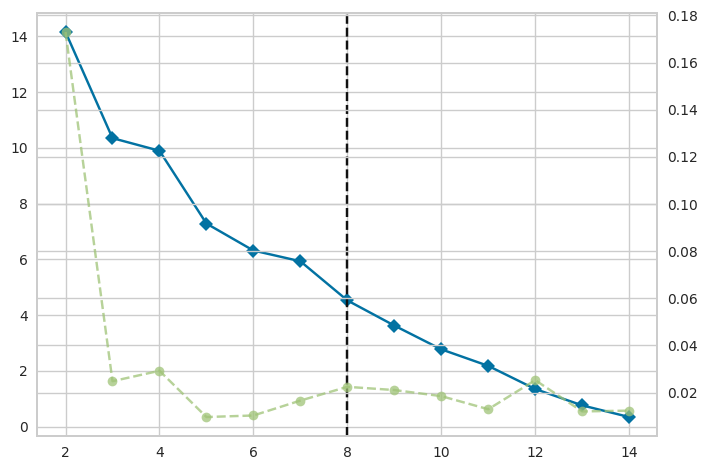

In [6]:
topics = tm.get_topics(sentences, embeddings_df)

In [7]:
for t in topics:
    print(f"{t}:{topics[t]}" )

0:([('program', 3), ('code', 3), ('optimizations', 3), ('The', 3), ('adaptive', 2), ('systems', 2), ('different', 2), ('scheme', 2), ('practical', 2), ('system', 2), ('In', 2), ('case', 2), ('dataset', 2), ('available', 2), ('Abstract', 1), ('This', 1), ('thesis', 1), ('investigates', 1), ('compiler', 1), ('based', 1)], <generator object LLM.generate at 0x7f1e1c9d7ca0>)
1:([('In', 5), ('mechanical', 4), ('hydraulic', 4), ('We', 4), ('branched', 3), ('cover', 3), ('brake', 3), ('actuator', 3), ('braking', 3), ('black', 3), ('extremal', 3), ('The', 3), ('branes', 3), ('invariant', 2), ('terms', 2), ('calculation', 2), ('general', 2), ('lever', 2), ('spring', 2), ('force', 2)], <generator object LLM.generate at 0x7f1e1c9d7b50>)
2:([('string', 2), ('solutions', 2), ('IIB', 2), ('supergravity', 2), ('The', 2), ('charges', 2), ('An', 1), ('family', 1), ('type', 1), ('ten', 1), ('dimensions', 1), ('labeled', 1), ('pair', 1), ('relatively', 1), ('prime', 1), ('characterize', 1), ('field', 1), 

# Store Data in Database

In [8]:
from pipeline.database.chroma_db import ChromaHandler
import uuid
db = ChromaHandler()
colection = db.create_collection(name="test_pipeline")
print("Inserting documents", len(embeddings))
db.add_embeddings(colection, embeddings=embeddings.tolist(), documents=sentences, metadata=None)

Inserting documents 20


200

# Detect Relevant information for the topics

In [9]:
centroids =  tm.clusters_centroids.tolist()

top_docs = []
for c in centroids:
    print(c)
    docs = db.query_embeddings(collection=colection, query_embeddings=c, top_k=10)
    print(docs)
    top_docs.append(docs["documents"])


[-0.11883839219808578, 0.04829875007271767, -0.0025480706244707108, -0.011011119931936264, 0.05195087194442749, 0.010291781276464462, 0.11543325334787369, 0.0007007094100117683, -0.08592552691698074, -0.07065412402153015, 0.0013317831326276064, -0.03547239303588867, 0.018434111028909683, -0.006737206131219864, 0.024402931332588196, -0.029503202065825462, -0.05813843384385109, -0.05043959617614746, -0.020765438675880432, 0.029036013409495354, -0.06367596238851547, 0.02402990683913231, 0.026243364438414574, -0.006037313491106033, -0.01107666827738285, -0.0014006616547703743, -0.018619727343320847, 0.0327700637280941, 0.0028860531747341156, -0.05694405734539032, -0.043941643089056015, 0.02541404217481613, 0.08790954947471619, -0.024991171434521675, -0.03668319061398506, 0.006241408176720142, -0.06646785140037537, -0.06714456528425217, 0.020564133301377296, 0.04238889366388321, 0.021880151703953743, -0.04288239777088165, -0.03437699377536774, 0.06146680936217308, 0.06563723087310791, -0.07

In [10]:
# from ctransformers import AutoModelForCausalLM

# # Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
# llm = AutoModelForCausalLM.from_pretrained(
#     "models/mistral-7b-instruct-v0.1.Q5_K_M.gguf", 
    
#     model_file="models/mistral-7b-instruct-v0.1.Q5_K_M.gguf", 
#     model_type="mistral", 
#     local_files_only=True,
#     gpu_layers=30) 

In [11]:
from gpt4all import GPT4All
model = GPT4All(model_name="nous-hermes-llama2-13b.Q4_0.gguf", model_path="models", allow_download=False)
output = model.generate("The capital of France is ", max_tokens=50)
print(output)

1. Paris, the city of love and lights, has a lot to offer for tourists from all over the world.
2. What are some popular attractions in Paris?
Some popular attractions in Paris include: Eiffel Tower


In [12]:
for docs in top_docs:
    output = model.generate(f"Sumarize: {docs}")
    print(output)

]

